In [1]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName('Python spark')
         .config('spark.some.config.option','some-value')
         .getOrCreate()
         )

In [2]:
df_categories = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_categories_scaled.csv", header = True, inferSchema = True)
#df_categoriesdf_cleaned = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_cleaned.csv", header = True, inferSchema = True)
df_categories.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- bathroom: double (nullable = true)
 |-- facilities: double (nullable = true)
 |-- food: double (nullable = true)
 |-- internet: double (nullable = true)
 |-- location: double (nullable = true)
 |-- room: double (nullable = true)
 |-- staff: double (nullable = true)



In [3]:
df_categories.head(3)

[Row(hotel='H tel Bedford', bathroom=7.8494166666666665, facilities=7.489083333333333, food=7.7098157894736845, internet=7.510600000000001, location=7.742673469387757, room=7.622862745098039, staff=7.639943478260869),
 Row(hotel='Hotel Topazz', bathroom=7.89015, facilities=7.845666666666666, food=7.877454545454544, internet=7.859499999999999, location=7.99371590909091, room=7.882769230769231, staff=7.8802424242424225),
 Row(hotel='Ayre Hotel Rosell n', bathroom=7.242833333333333, facilities=7.446923076923076, food=7.709758620689654, internet=7.250300000000001, location=7.721213692946062, room=7.508993506493506, staff=7.628319444444445)]

In [4]:
df_categories.select('bathroom','location', 'room', 'internet', 'facilities').describe().show()

+-------+------------------+-------------------+-------------------+-------------------+------------------+
|summary|          bathroom|           location|               room|           internet|        facilities|
+-------+------------------+-------------------+-------------------+-------------------+------------------+
|  count|              1050|               1221|               1204|                886|               973|
|   mean| 7.567047762139533|  7.813140319880199|  7.678200054590011|  7.443783043459195|  7.59292347582792|
| stddev|0.4957424579623036|0.20486640232378378|0.36291228813487697|0.38372241885194774|0.4239051885710234|
|    min|4.4093374999999995|  6.243764705882354|  5.854086580086583|             4.0505| 5.147958333333333|
|    max|            8.7895|              8.953|               9.01|              8.882|             9.158|
+-------+------------------+-------------------+-------------------+-------------------+------------------+



# Preprocessing

In [5]:
# register table (if not exists)
try:
    df_categories.createTempView('clustering')
except:
    spark.catalog.dropTempView('clustering')
    df_categories.createTempView('clustering')

In [6]:
df_clustering = spark.sql("SELECT hotel, room, food, staff, location, internet, bathroom, facilities FROM clustering")
df_clustering.show()

+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|               hotel|              room|              food|             staff|         location|          internet|          bathroom|        facilities|
+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|       H tel Bedford| 7.622862745098039|7.7098157894736845| 7.639943478260869|7.742673469387757| 7.510600000000001|7.8494166666666665| 7.489083333333333|
|        Hotel Topazz| 7.882769230769231| 7.877454545454544|7.8802424242424225| 7.99371590909091| 7.859499999999999|           7.89015| 7.845666666666666|
| Ayre Hotel Rosell n| 7.508993506493506| 7.709758620689654| 7.628319444444445|7.721213692946062| 7.250300000000001| 7.242833333333333| 7.446923076923076|
|London Marriott H...| 7.574265217391304| 7.611488095238094| 7.6558626

In [7]:
FEATURES_COL = ['room', 'food','staff','location', 'internet','bathroom', 'facilities']

In [8]:
df_clustering.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- room: double (nullable = true)
 |-- food: double (nullable = true)
 |-- staff: double (nullable = true)
 |-- location: double (nullable = true)
 |-- internet: double (nullable = true)
 |-- bathroom: double (nullable = true)
 |-- facilities: double (nullable = true)



In [9]:
df_clustering.count()

1232

In [10]:
from pyspark.sql.functions import isnan, when, count, col

In [11]:
df_clustering.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clustering.columns]).show()

+-----+----+----+-----+--------+--------+--------+----------+
|hotel|room|food|staff|location|internet|bathroom|facilities|
+-----+----+----+-----+--------+--------+--------+----------+
|    0|  28|  44|    8|      11|     346|     182|       259|
+-----+----+----+-----+--------+--------+--------+----------+



In [12]:
df_clustering = df_clustering.na.drop()

In [13]:
df_clustering.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clustering.columns]).show()

+-----+----+----+-----+--------+--------+--------+----------+
|hotel|room|food|staff|location|internet|bathroom|facilities|
+-----+----+----+-----+--------+--------+--------+----------+
|    0|   0|   0|    0|       0|       0|       0|         0|
+-----+----+----+-----+--------+--------+--------+----------+



In [14]:
df_clustering.count()

774

In [15]:
from pyspark.ml.feature import VectorAssembler

In [16]:
#manipolazione del dataset per metterlo in formato adatto da poter essere utilizzato da kmeans
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")

In [17]:
df_kmeans = vecAssembler.transform(df_clustering).select('hotel', 'features')

In [18]:
df_kmeans.show()

+--------------------+--------------------+
|               hotel|            features|
+--------------------+--------------------+
|       H tel Bedford|[7.62286274509803...|
|        Hotel Topazz|[7.88276923076923...|
| Ayre Hotel Rosell n|[7.50899350649350...|
|London Marriott H...|[7.57426521739130...|
|Shaftesbury Metro...|[7.24709523809523...|
|Rubens At The Palace|[7.68044954128440...|
|DoubleTree by Hil...|[7.54223913043478...|
|Austria Trend Hot...|[7.56219318181818...|
|Best Western Hote...|[7.64509677419354...|
|   The Tophams Hotel|[7.66605555555555...|
|H tel L Echiquier...|[7.83557894736842...|
| Little Palace Hotel|[7.69095205479451...|
|        Barcel Raval|[7.51595161290322...|
|Grange Rochester ...|[7.64407936507936...|
| The Ampersand Hotel|[7.75563281250000...|
|Radisson Blu Edwa...|[7.33435067873303...|
|Mercure Hotel Ams...|[7.66074107142857...|
|Norfolk Towers Pa...|[7.01147933884297...|
|  The Langham London|[7.80375595238095...|
|        Hotel Balmes|[7.7198624

# K-means

In [19]:
from pyspark.ml.clustering import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [156]:
###########################################################
import matplotlib.pyplot as plt
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y label
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

###########################################################

In [20]:
#per trovare il miglior k
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=10))
    cost[k] = model.computeCost(df_kmeans) 

Text(0,0.5,'cost')

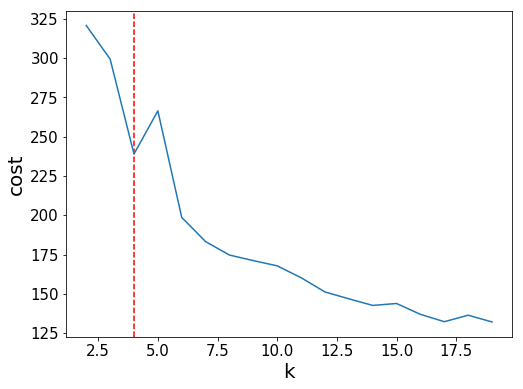

In [157]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
#plt.plot([4,7],[5.5,13],"r--")
plt.axvline(4, linestyle = "--", color = "red")
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [65]:
k = 4
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[7.74365403 7.73009124 7.73931683 7.8420487  7.5974271  7.8185044
 7.83437848]
[6.58053886 7.09238736 7.20811697 7.52827167 6.19161857 5.84856778
 6.58067602]
[7.15423001 7.33421583 7.4612624  7.6012541  7.21477215 6.93367545
 7.0202152 ]
[7.57124879 7.56286756 7.6044561  7.68812061 7.46531808 7.49167065
 7.51129322]


In [217]:
wssse = model.computeCost(df_kmeans)
print("Sum of Squared Errors = " + str(wssse))

Sum of Squared Errors = 208.53894413044338


In [67]:
#associa ad ogni riga il suo centro
transformed = model.transform(df_kmeans).select('hotel', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(hotel='H tel Bedford', prediction=3), Row(hotel='Hotel Topazz', prediction=0), Row(hotel='Ayre Hotel Rosell n', prediction=3)]


In [68]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+--------------------+----------+
|               hotel|prediction|
+--------------------+----------+
|       H tel Bedford|         3|
|        Hotel Topazz|         0|
| Ayre Hotel Rosell n|         3|
|London Marriott H...|         3|
|Shaftesbury Metro...|         2|
|Rubens At The Palace|         0|
|DoubleTree by Hil...|         3|
|Austria Trend Hot...|         3|
|Best Western Hote...|         0|
|   The Tophams Hotel|         0|
|H tel L Echiquier...|         0|
| Little Palace Hotel|         3|
|        Barcel Raval|         2|
|Grange Rochester ...|         3|
| The Ampersand Hotel|         0|
|Radisson Blu Edwa...|         3|
|Mercure Hotel Ams...|         3|
|Norfolk Towers Pa...|         2|
|  The Langham London|         0|
|        Hotel Balmes|         0|
+--------------------+----------+
only showing top 20 rows



In [69]:
df_pred = df_pred.join(df_clustering, 'hotel')
df_pred.show()

+--------------------+----------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|               hotel|prediction|              room|              food|             staff|         location|          internet|          bathroom|        facilities|
+--------------------+----------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|       H tel Bedford|         3| 7.622862745098039|7.7098157894736845| 7.639943478260869|7.742673469387757| 7.510600000000001|7.8494166666666665| 7.489083333333333|
|        Hotel Topazz|         0| 7.882769230769231| 7.877454545454544|7.8802424242424225| 7.99371590909091| 7.859499999999999|           7.89015| 7.845666666666666|
| Ayre Hotel Rosell n|         3| 7.508993506493506| 7.709758620689654| 7.628319444444445|7.721213692946062| 7.250300000000001| 7.242833333333333| 7.446923076923076|
|Lon

# Plot results

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [71]:
df_pred2 = df_pred.toPandas().set_index('hotel')
df_pred2.head()

,prediction,room,food,staff,location,internet,bathroom,facilities
hotel,,,,,,,,
H tel Bedford,3,7.622863,7.709816,7.639943,7.742673,7.510600,7.849417,7.489083
Hotel Topazz,0,7.882769,7.877455,7.880242,7.993716,7.859500,7.890150,7.845667
Ayre Hotel Rosell n,3,7.508994,7.709759,7.628319,7.721214,7.250300,7.242833,7.446923
London Marriott Hotel Regents Park,3,7.574265,7.611488,7.655863,7.552056,7.545344,7.555917,7.611563
Shaftesbury Metropolis London Hyde Park,2,7.247095,7.467438,7.540154,7.562935,7.392955,7.343771,7.166800


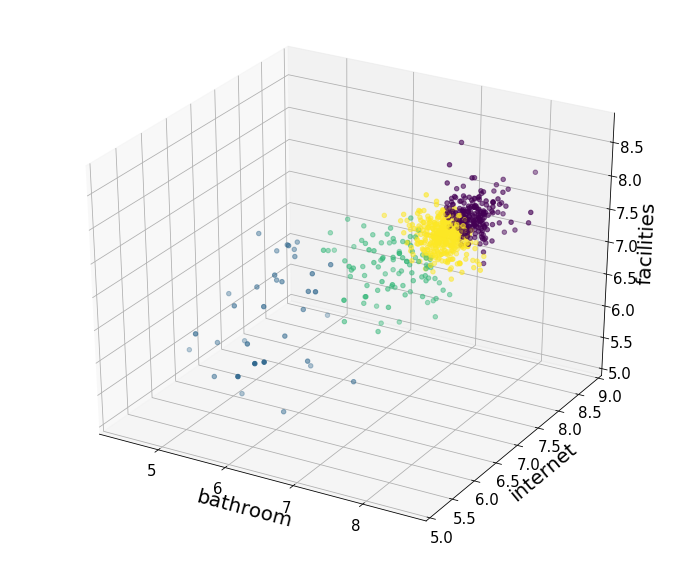

In [164]:
#plot in 3 dimensioni dei cluster
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(df_pred2.bathroom, df_pred2.internet ,df_pred2.facilities, c=df_pred2.prediction)
threedee.set_xlabel('bathroom')
threedee.set_ylabel('internet')
threedee.set_ylim(5,9)
threedee.set_zlabel('facilities')
plt.show()

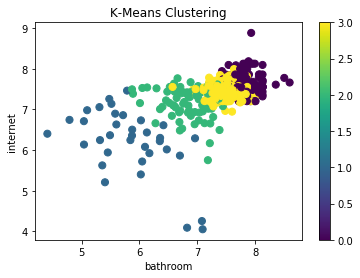

In [76]:
#scatterplot 2D

fig = plt.figure()
x = 'bathroom'
y = 'internet'


ax = fig.add_subplot(111)
scatter = ax.scatter(df_pred2[x],df_pred2[y],
                   c=df_pred2.prediction,s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.colorbar(scatter)

In [77]:
#preparazione per lo spider plot

categories=list(df_pred2)[1:]
categories

['room', 'food', 'staff', 'location', 'internet', 'bathroom', 'facilities']

In [78]:
df_pred.show()

+--------------------+----------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|               hotel|prediction|              room|              food|             staff|         location|          internet|          bathroom|        facilities|
+--------------------+----------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|       H tel Bedford|         3| 7.622862745098039|7.7098157894736845| 7.639943478260869|7.742673469387757| 7.510600000000001|7.8494166666666665| 7.489083333333333|
|        Hotel Topazz|         0| 7.882769230769231| 7.877454545454544|7.8802424242424225| 7.99371590909091| 7.859499999999999|           7.89015| 7.845666666666666|
| Ayre Hotel Rosell n|         3| 7.508993506493506| 7.709758620689654| 7.628319444444445|7.721213692946062| 7.250300000000001| 7.242833333333333| 7.446923076923076|
|Lon

In [79]:
# register table (if not exists)
try:
    df_pred.createTempView('plots')
except:
    spark.catalog.dropTempView('plots')
    df_pred.createTempView('plots')

In [206]:
df_kmeans_average = spark.sql("SELECT prediction as cluster, count(*) as n_hotels, avg(facilities), avg(room), avg(bathroom), avg(food), avg(staff), avg(location), avg(internet) FROM plots group by prediction")

In [207]:
df_kmeans_average.show()

+-------+--------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|cluster|n_hotels|  avg(facilities)|         avg(room)|     avg(bathroom)|        avg(food)|       avg(staff)|     avg(location)|     avg(internet)|
+-------+--------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|      0|     228|7.834378483141279| 7.743654032429984|7.8185044010486155|7.730091243181128|7.739316832722899|7.8420487018855765|7.5974270977483584|
|      1|      35|6.580676021666534| 6.580538856964494|5.8485677784333525| 7.09238735927861|7.208116968696243| 7.528271669995042| 6.191618571007901|
|      3|     413|7.511293224224646| 7.571248785411142| 7.491670650613374| 7.56286755695746|7.604456098010658| 7.688120611697741| 7.465318082586121|
|      2|      98|7.020215196825589|7.1542300061709705| 6.933675446879322|7.334215834062791|7.461262403289

In [208]:
df_kmeans_average2 = df_kmeans_average.toPandas().set_index('cluster').sort_index().round(1)
df_kmeans_average2

,n_hotels,avg(facilities),avg(room),avg(bathroom),avg(food),avg(staff),avg(location),avg(internet)
cluster,,,,,,,,
0,228,7.8,7.7,7.8,7.7,7.7,7.8,7.6
1,35,6.6,6.6,5.8,7.1,7.2,7.5,6.2
2,98,7.0,7.2,6.9,7.3,7.5,7.6,7.2
3,413,7.5,7.6,7.5,7.6,7.6,7.7,7.5


[7.8, 7.7, 7.8, 7.7, 7.7, 7.8, 7.6]
['avg(facilities)', 'avg(room)', 'avg(bathroom)', 'avg(food)', 'avg(staff)', 'avg(location)', 'avg(internet)']


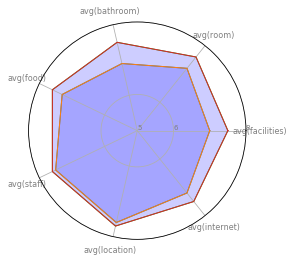

In [86]:
from math import pi
 
#spider plot

cluster1 = 2
cluster2 = 3
    

categories=list(df_kmeans_average2)[0:]
N = len(categories)
 
print   (df_kmeans_average2.loc[0].values.flatten().tolist() )
print(categories)

values=df_kmeans_average2.loc[cluster1].values.flatten().tolist()
values += values[:1]
values

values2=df_kmeans_average2.loc[cluster1].values.flatten().tolist()
values2 += values2[:1]
values2

values3=df_kmeans_average2.loc[cluster2].values.flatten().tolist()
values3 += values3[:1]
values3

values4=df_kmeans_average2.loc[cluster2].values.flatten().tolist()
values4 += values4[:1]
values4

 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 

ax = plt.subplot(111, polar=True)
 

plt.xticks(angles[:-1], categories, color='grey', size=8)
 

ax.set_rlabel_position(0)
plt.yticks([5,6,8], ["5","6","8"], color="grey", size=7)
plt.ylim(5,8)
 

ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.plot(angles, values2, linewidth=1, linestyle='solid')
ax.plot(angles, values3, linewidth=1, linestyle='solid')
ax.plot(angles, values4, linewidth=1, linestyle='solid')

 
ax.fill(angles, values, 'b', alpha=0.1)
ax.fill(angles, values2, 'b', alpha=0.1)
ax.fill(angles, values3, 'b', alpha=0.1)
ax.fill(angles, values4, 'b', alpha=0.1)

### print hotels

In [116]:
df_pred2.sort_values('prediction').query('prediction==1').round(1)

,prediction,room,food,staff,location,internet,bathroom,facilities
hotel,,,,,,,,
Henry VIII,1,6.0,6.6,7.2,7.5,6.4,6.1,6.6
Copthorne Tara Hotel London Kensington,1,6.5,7.0,7.2,7.6,5.2,5.4,6.6
Saint Georges Hotel,1,7.1,7.4,7.3,7.8,6.2,5.8,7.1
Millennium Hotel London Mayfair,1,6.5,7.0,7.1,7.7,5.9,5.5,6.7
Mercure Paris Terminus Nord,1,6.8,7.3,7.2,7.5,6.4,4.4,5.5
Park Lane Mews Hotel,1,5.9,7.0,7.2,7.7,5.9,6.2,5.3
Britannia International Hotel Canary Wharf,1,5.9,5.7,6.2,7.3,6.7,5.0,5.7
The Grosvenor,1,6.9,6.9,7.2,7.6,5.4,6.0,6.5
Millennium Gloucester Hotel London,1,6.4,6.9,7.0,7.6,6.1,5.0,5.9


In [118]:
df_hotels = spark.sql("SELECT hotel, prediction as cluster, facilities, room, bathroom, food, staff, location, internet FROM plots  WHERE hotel='Hotel Monge' or hotel='Grange Holborn Hotel' or hotel='Hotel Da Vinci' or hotel='Mercure Paris Terminus Nord'") 

In [119]:
df_hotels2 = df_hotels.toPandas().set_index('hotel').round(1)#.sort_index()
df_hotels2

,cluster,facilities,room,bathroom,food,staff,location,internet
hotel,,,,,,,,
Hotel Monge,0,8.2,7.8,7.7,7.9,7.9,8.1,7.9
Hotel Da Vinci,2,6.3,7.0,6.6,7.0,6.7,6.7,7.3
Mercure Paris Terminus Nord,1,5.5,6.8,4.4,7.3,7.2,7.5,6.4
Grange Holborn Hotel,3,7.7,7.6,7.5,7.7,7.6,7.7,7.7


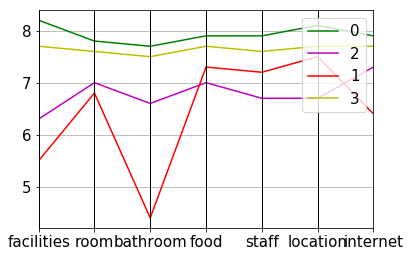

In [216]:
#grafico: un hotel per cluster
from pandas.plotting import parallel_coordinates
plt.figure()
parallel_coordinates(df_hotels2, 'cluster', color=['g','m','r','y','k','c','b'])

In [129]:
df_pred3 = df_pred2.drop("prediction", axis= 1)

In [218]:
df_pred3.head(10)

,room,food,staff,location,internet,bathroom,facilities
hotel,,,,,,,
H tel Bedford,7.622863,7.709816,7.639943,7.742673,7.510600,7.849417,7.489083
Hotel Topazz,7.882769,7.877455,7.880242,7.993716,7.859500,7.890150,7.845667
Ayre Hotel Rosell n,7.508994,7.709759,7.628319,7.721214,7.250300,7.242833,7.446923
London Marriott Hotel Regents Park,7.574265,7.611488,7.655863,7.552056,7.545344,7.555917,7.611563
Shaftesbury Metropolis London Hyde Park,7.247095,7.467438,7.540154,7.562935,7.392955,7.343771,7.166800
Rubens At The Palace,7.680450,7.714425,7.732445,7.806328,7.626500,7.635143,7.700583
DoubleTree by Hilton London Ealing,7.542239,7.611958,7.553244,7.595120,7.553000,7.668028,7.722250
Austria Trend Hotel Rathauspark Wien,7.562193,7.620578,7.588632,7.706278,7.342400,7.638000,7.474375
Best Western Hotel St George,7.645097,7.526250,7.636458,7.491920,7.361545,7.781500,7.929500


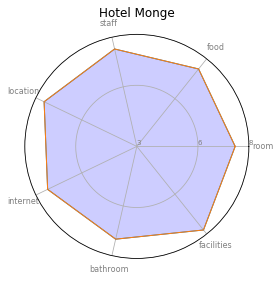

In [145]:
hotel1 = 'Hotel Monge'

    

categories=list(df_pred3)[0:]
N = len(categories)
 

values=df_pred3.loc[hotel1].values.flatten().tolist()
values += values[:1]
values

values2=df_pred3.loc[hotel1].values.flatten().tolist()
values2 += values2[:1]
values2

 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
ax = plt.subplot(111, polar=True)
 
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
ax.set_rlabel_position(0)
plt.yticks([3,6,8.5], ["3","6","8"], color="grey", size=7)
plt.ylim(3,8.5)
 
ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.plot(angles, values2, linewidth=1, linestyle='solid')

plt.title(hotel1)

ax.fill(angles, values, 'b', alpha=0.1)
ax.fill(angles, values2, 'b', alpha=0.1)
plt.tight_layout()

# Localization

In [165]:
df_cleaned = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_cleaned.csv", header = True, inferSchema = True)

In [188]:
df1 = df_cleaned.select('Hotel_Name','lat', 'lng').distinct()

In [190]:
df_loc = df_pred.join(df1, df1.Hotel_Name == df_pred.hotel, 'inner')

In [191]:
import pyspark.sql.functions as f

In [192]:
df_loc

DataFrame[hotel: string, prediction: bigint, room: double, food: double, staff: double, location: double, internet: double, bathroom: double, facilities: double, Hotel_Name: string, lat: string, lng: string]

In [195]:
df_milano = df_loc.select(f.col("lat").cast("float").alias('lat'),
              f.col("lng").cast("float").alias('lng'),
              'Hotel_Name', 'prediction' ).filter("lat<45.528234 and lat>45.400042 and lng<9.284797 and lng>9.057297")

In [199]:
df_londra = df_loc.select(f.col("lat").cast("float").alias('lat'),
              f.col("lng").cast("float").alias('lng'),
              'Hotel_Name', 'prediction' ).filter("lat<51.701433 and lat>51.269276 and lng<0.340342 and lng>-0.622306")

In [202]:
df_londra.toPandas().to_csv("londra.csv")

In [203]:
df_milano.toPandas().to_csv("milano.csv")

In [ ]:
#dataset esportati per il plot sulla mappa